In [1]:
pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 56.2MB/s 
     |████████████████████████████████| 512kB 58.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=20864fe4801e2f9ce3bbbf46d7af4459dd595f381997f196070fcfa3823cee2d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import os

In [0]:
INPUT_SIGNAL_TYPES=[
                    "body_acc_x_",
                    "body_acc_y_",
                    "body_acc_z_",
                    "body_gyro_x_",
                    "body_gyro_y_",
                    "body_gyro_z_",
                    "total_acc_x_",
                    "total_acc_y_",
                    "total_acc_z_"
]

LABELS=[
        "WALKING",
        "WALKING_UPSTAIRS",
        "WALKING_DOWNSTAIRS",
        "SITTING",
        "STANDING",
        "LAYING"
]

In [0]:
PATH="drive/My Drive/Colab/MS Project/UCI HAR Dataset/UCI HAR Dataset/"
TRAIN="train/"
TEST="test/"

def load_X(X_signals_paths):
  X_signals=[]

  for signal_type_path in X_signals_paths:
    file=open(signal_type_path,'r')
    X_signals.append([np.array(serie,dtype=np.float32) for serie in [row.replace('  ',' ').strip().split(' ') for row in file]])
    file.close()

  return np.transpose(np.array(X_signals),(1,2,0))

X_train_signals_paths=[PATH+TRAIN+"Inertial Signals/"+signal+"train.txt" for signal in INPUT_SIGNAL_TYPES]

X_test_signals_paths=[PATH+TEST+"Inertial Signals/"+signal+"test.txt" for signal in INPUT_SIGNAL_TYPES]

X_train=load_X(X_train_signals_paths)
X_test=load_X(X_test_signals_paths)

def load_y(y_path):
  file=open(y_path,'r')
  y_=np.array([elem for elem in [row.replace('  ',' ').strip().split(' ') for row in file]],dtype=np.int32)
  file.close()

  return y_ - 1

y_train_path=PATH+TRAIN+"y_train.txt"
y_test_path=PATH+TEST+"y_test.txt"

y_train=load_y(y_train_path)
y_test=load_y(y_test_path)

In [5]:
training_data_count=len(X_train)
test_data_count=len(X_test)
n_steps=len(X_train[0])
n_input=len(X_train[0][0])

n_hidden=32
n_classes=6

learning_rate=0.0025
lambda_loss_amount=0.0015
training_iters=training_data_count*300
batch_size=1500
display_iter=30000

print("Some useful info to get an insight on dataset's shape and normalization")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape,y_test.shape,np.mean(X_test),np.std(X_test))
print(" The datatset is properly normalized but not yet one-hot encoded")

Some useful info to get an insight on dataset's shape and normalization
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
 The datatset is properly normalized but not yet one-hot encoded


In [0]:
def LSTM_RNN(_X, _weights,_biases):
  _X=tf.transpose(_X,[1,0,2])
  _X=tf.reshape(_X,[-1,n_input])

  _X=tf.nn.relu(tf.matmul(_X,_weights['hidden'])+_biases['hidden'])
  _X=tf.split(_X,n_steps,0)

  lstm_cell_1=tf.contrib.rnn.BasicLSTMCell(n_hidden,forget_bias=1.0,state_is_tuple=True)
  lstm_cell_2=tf.contrib.rnn.BasicLSTMCell(n_hidden,forget_bias=1.0,state_is_tuple=True)
  lstm_cells=tf.contrib.rnn.MultiRNNCell([lstm_cell_1,lstm_cell_2],state_is_tuple=True)

  outputs,states=tf.contrib.rnn.static_rnn(lstm_cells,_X,dtype=tf.float32)

  lstm_last_output=outputs[-1]

  return tf.matmul(lstm_last_output,_weights['out']+biases['out'])

In [0]:
def extract_batch_size(_train,step,batch_size):
  shape=list(_train.shape)
  shape[0]=batch_size
  batch_s=np.empty(shape)

  for i in range(batch_size):

    index=((step-1)*batch_size+i)%len(_train)
    batch_s[i]=_train[index]

  return batch_s

In [0]:
def one_hot(y_,n_classes=n_classes):
  y_=y_.reshape(len(y_))

  return np.eye(n_classes)[np.array(y_,dtype=np.int32)]

In [9]:
x=tf.placeholder(tf.float32,[None,n_steps,n_input])
y=tf.placeholder(tf.float32,[None,n_classes])

weights={
    'hidden':tf.Variable(tf.random_normal([n_input,n_hidden])),
    'out':tf.Variable(tf.random_normal([n_hidden,n_classes],mean=1.0))
}
biases={
    'hidden':tf.Variable(tf.random_normal([n_hidden])),
    'out':tf.Variable(tf.random_normal([n_classes]))
}
pred=LSTM_RNN(x,weights,biases)

l2=lambda_loss_amount*sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))+l2
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred=tf.equal(tf.argmax(pred,1),tf.argmax(y,1),name="y_")
accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will al

In [10]:

test_losses=[]
test_accuracies=[]
train_losses=[]
train_accuracies=[]
global accuracy 
saver = tf.train.Saver()

history = dict(train_losses=[], 
                     train_accuracies=[], 
                     test_losses=[], 
                     test_accuracies=[])

sess=tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init=tf.global_variables_initializer()
sess.run(init)

step=1

while step*batch_size<=training_iters:
  batch_xs=extract_batch_size(X_train,step,batch_size)
  batch_ys=one_hot(extract_batch_size(y_train,step,batch_size))

  _,loss,acc=sess.run([optimizer,cost,accuracy],feed_dict={
      x:batch_xs,
      y:batch_ys
  })
  train_losses.append(loss)
  train_accuracies.append(acc)
  history['train_losses'].append(loss)
  history['train_accuracies'].append(acc)
    
  if (step*batch_size%display_iter==0)or(step==1)or(step*batch_size>training_iters):

    print("Training iter #"+ str(step*batch_size)+\
          ":    Batch Loss= "+ "{:.6f}".format(loss)+\
          ", Accuracy = {}".format(acc))
    
    loss,acc=sess.run([cost,accuracy],feed_dict={
        x:X_test,
        y:one_hot(y_test)
    })
    test_losses.append(loss)
    test_accuracies.append(acc)
    history['test_losses'].append(loss)
    history['test_accuracies'].append(acc)
    print("PERFOMANCE IN TEST SET: " + \
          "Batch Loss ={}".format(loss)+ \
          ",Accuracy ={}".format(acc))
    
  step+=1

print("Optimization Finished!")


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Training iter #1500:    Batch Loss= 3.073489, Accuracy = 0.06199999898672104
PERFOMANCE IN TEST SET: Batch Loss =2.6085433959960938,Accuracy =0.1940956860780716
Training iter #30000:    Batch Loss= 1.390762, Accuracy = 0.6420000195503235
PERFOMANCE IN TEST SET: Batch Loss =1.4255834817886353,Accuracy =0.6484560370445251
Training iter #60000:    Batch Loss= 1.214823, Accuracy = 0.7200000286102295
PERFOMANCE IN TEST SET: Batch Loss =1.323338508605957,Accuracy =0.7098744511604309
Training iter #90000:    Batch Loss= 1.015152, Accuracy = 0.8399999737739563
PERFOMANCE IN TEST SET: Batch Loss =1.1879920959472656,Accuracy =0.8065829873085022
Training iter #120000:    Batch Loss= 0.831795, Accur

In [11]:
#%timeit one_hot_predictions,accuracy,final_loss=sess.run([pred,accuracy,cost],feed_dict={ x:X_test, y:one_hot(y_test)})
%%time
one_hot_predictions,accuracy,final_loss=sess.run([pred,accuracy,cost],
                                                feed_dict={
                                                    x:X_test,
                                                    y:one_hot(y_test)
                                                })



test_losses.append(final_loss)
test_accuracies.append(acc)
#%timeit one_hot_predictions,accuracy,final_loss=sess.run([pred,accuracy,cost],feed_dict={ x:X_test, y:one_hot(y_test)})
print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss)+\
      ", Accuracy ={}".format(accuracy))


FINAL RESULT: Batch Loss = 0.4447685480117798, Accuracy =0.9063454270362854
CPU times: user 503 ms, sys: 22.2 ms, total: 525 ms
Wall time: 719 ms


In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams 
from sklearn import metrics
from sklearn.model_selection import train_test_split

pickle.dump(one_hot_predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', 'LSTM_RNN_har.pbtxt')  
saver.save(sess, save_path = "LSTM_RNN_har.ckpt")
sess.close()

In [0]:

history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))



findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


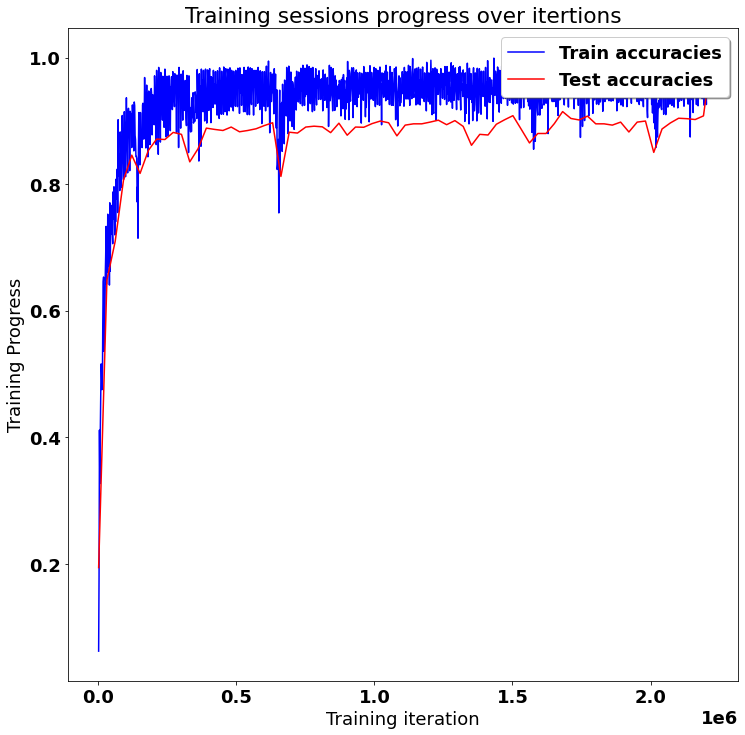

In [15]:
%matplotlib inline

font={
    'family':'Bitstream Vera Sans',
    'weight':'bold',
    'size':18
}

matplotlib.rc('font',**font)

width=12
height=12
plt.figure(figsize=(width,height))

indep_train_axis=np.array(range(batch_size,(len(train_losses)+1)*batch_size,batch_size))

plt.plot(indep_train_axis,np.array(train_accuracies),   "b-",label="Train accuracies")

indep_test_axis=np.append(np.array(range(batch_size,(len(test_losses)+1)*display_iter,display_iter))[:-2],[training_iters])

plt.plot(indep_test_axis,np.array(test_accuracies),   "r-",label="Test accuracies")

plt.title("Training sessions progress over itertions")
plt.legend(loc='upper right',shadow=True)
plt.xlabel('Training iteration')
plt.ylabel('Training Progress')

plt.show()

Testing Accuracy: 90.63454270362854%

Precision: 90.9084466133117%
Recall: 90.63454360366474%
f1_score: 90.63577814510147%

Confusion Matrix:
[[459   1  36   0   0   0]
 [  8 427  36   0   0   0]
 [  7   3 410   0   0   0]
 [  0   5   0 417  63   6]
 [  4   1   0 106 421   0]
 [  0   0   0   0   0 537]]

Confusion matrix (normalised to % of total test data):
[[15.575162    0.03393281  1.2215812   0.          0.          0.        ]
 [ 0.2714625  14.489311    1.2215812   0.          0.          0.        ]
 [ 0.2375297   0.10179844 13.912453    0.          0.          0.        ]
 [ 0.          0.16966406  0.         14.149983    2.137767    0.20359688]
 [ 0.13573125  0.03393281  0.          3.596878   14.285715    0.        ]
 [ 0.          0.          0.          0.          0.         18.22192   ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


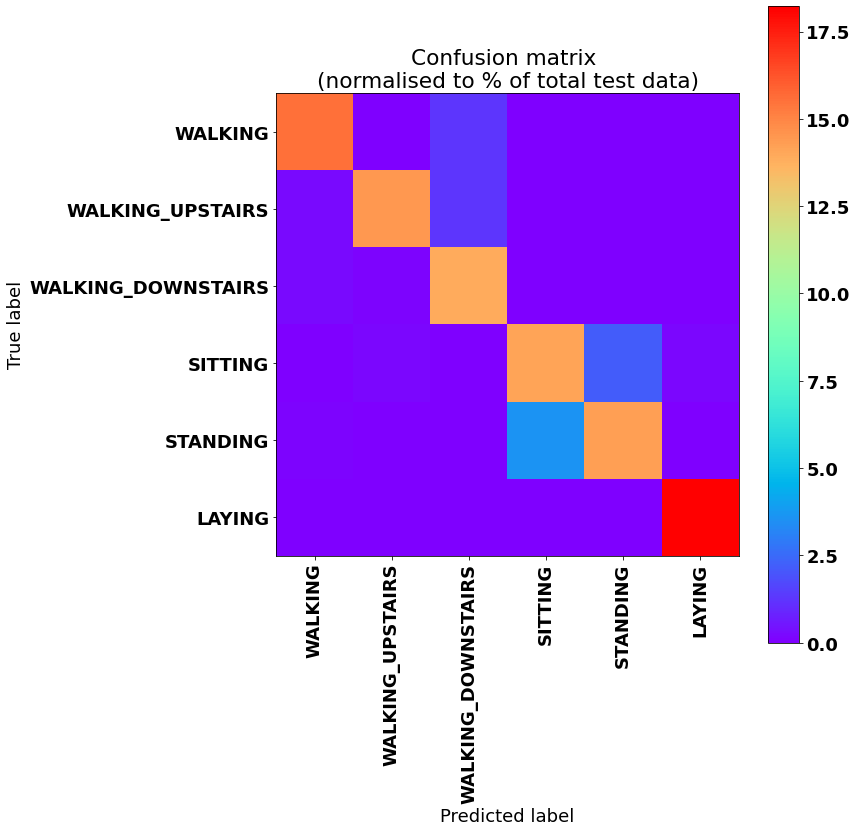

In [16]:
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'LSTM_RNN_har'

input_graph_path = MODEL_NAME+'.pbtxt'
checkpoint_path = 'LSTM_RNN_har.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from LSTM_RNN_har.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 128
        }
        dim {
          size: 9
        }
      }
    }
  }
}
node {
  name: "Placeholder_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 6
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 9
          }
          dim {
            size: 32
          }
        }
        tensor_content: "\035-B\277}\313M\276\362ix>\336\223%>\340\035Y\276\251\000\310\